In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - "03_25_24_RandomCircles_RandomMiscalEnsembles"
    
calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_baseline_rows: False 
    load_pixel_meters: False 
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    load_groupavg_metrics: False
    remove_shared_columns: False
    equal_rows_per_cfg_assert: True 

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 92340 -> 92340 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                                                log_set                                              
/storage/vbutoi/scratch/ESE/inference/03_21_24_RandomCircles_RandomMiscalibratedEnsembles/Shapes_Ensemble_Uncalibrated  20240321_172845-8VPT-da548ec0c9d006986cddb3da7c103b64    1620
                                                                                                                        20240321_172849-PYU7-eb5c251928c87b3e63a71a72e14b2292    1620
                                                                                                                        20240321_172852-U5LW-af10b5ba648a9bc317b64f91a4aed108    1620
                                                                                                                        20240321_172854-9HKT-

In [4]:
import ast
import numpy as np

# def temp_1(member_temps):
#     return ast.literal_eval(member_temps)[0]
# def temp_2(member_temps):
#     return ast.literal_eval(member_temps)[1]

def temp_mean(member_temps):
    return np.mean(ast.literal_eval(member_temps))

def temp_variance(member_temps):
    return np.var(ast.literal_eval(member_temps))

image_info_df.augment(temp_mean)
image_info_df.augment(temp_variance)

In [5]:
image_info_df['temp_variance'].unique()

array([5.87155236e+02, 1.13186264e+03, 2.49205907e+01, 1.17986241e-02,
       7.61487514e+02, 5.20121614e+02, 1.48927433e+03, 3.09463958e+02,
       2.18282672e+03, 1.10364390e+03, 1.15730756e+03, 4.90034705e+02,
       4.31082493e-01, 1.23417976e+02, 1.27624582e+03, 8.25115969e+02,
       3.88985403e+02, 7.34286716e+02, 1.09061332e+03, 3.67296284e+02,
       3.35742141e+02, 5.09598186e+02, 6.27078501e+00, 1.09606962e+03,
       1.23387745e+03, 1.36886498e+03, 1.23819616e+03, 1.51145760e+03,
       1.13704030e+03, 2.53394489e+01, 1.25187028e+03, 5.20373638e+01,
       9.56904799e+02, 1.03589197e+03, 8.16327221e+02, 1.39268139e+02,
       9.20236580e+01, 5.13744982e+02, 1.23787976e+03, 1.00504649e+03,
       1.79460503e+03, 1.81045369e+02, 4.60800957e+02, 1.03534147e+03,
       4.87432000e+02, 1.35623663e+03, 1.63066198e+02, 2.38533508e+00,
       3.77490777e+02, 1.56318619e+02, 1.22147191e+03, 5.36431033e+02,
       1.10887096e+03, 9.89842561e+02, 2.17435733e+02, 9.54286470e+02,
      

In [6]:
# Select only the rows corresponding to group methods
image_info_df = image_info_df[image_info_df['model_type'] == 'group']

image_info_df['method_name'] = image_info_df['method_name'].astype('category')
image_info_df['method_name'] = image_info_df['method_name'].cat.reorder_categories([
    'Ensemble (mean, probs)', 
])

image_info_df['split'] = image_info_df['split'].astype('category')
image_info_df['split'] = image_info_df['split'].cat.reorder_categories([
    'val',
    'cal'
])

In [7]:
image_info_df['image_metric'].unique()

array(['Dice', 'HD95', 'BoundaryIOU', 'Accuracy', 'Recall', 'Precision',
       'Pixel-Ambiguity', 'Soft-Region-Ambiguity',
       'Hard-Region-Ambiguity', 'Image_ECE', 'Image_Edge-ECE',
       'Image_CW-ECE', 'Image_ECW-ECE', 'Image_Uniform-CW-ECE',
       'Image_Uniform-ECW-ECE', 'Image_ELM', 'Image_Edge-ELM',
       'Image_Uniform-ELM', 'Image_Uniform-Edge-ELM', 'Dice Loss'],
      dtype=object)

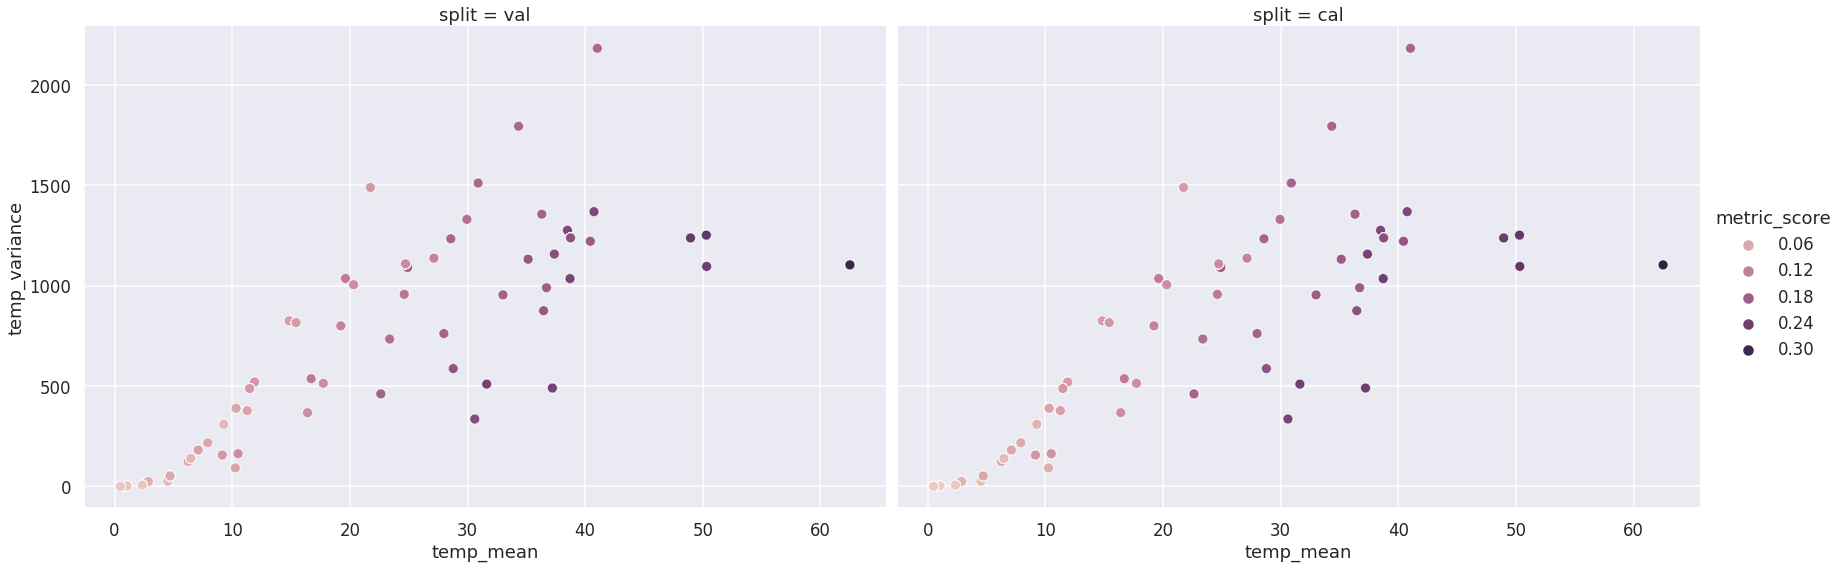

In [8]:
metric_df = image_info_df[image_info_df['image_metric'] == 'Image_ECE']

g = sns.relplot(
    data=metric_df,
    x='temp_mean',
    y='temp_variance',
    hue='metric_score',
    col='split',
    kind='scatter',
    height=8,
    aspect=1.5,
    s=100,
    alpha=0.7,
)

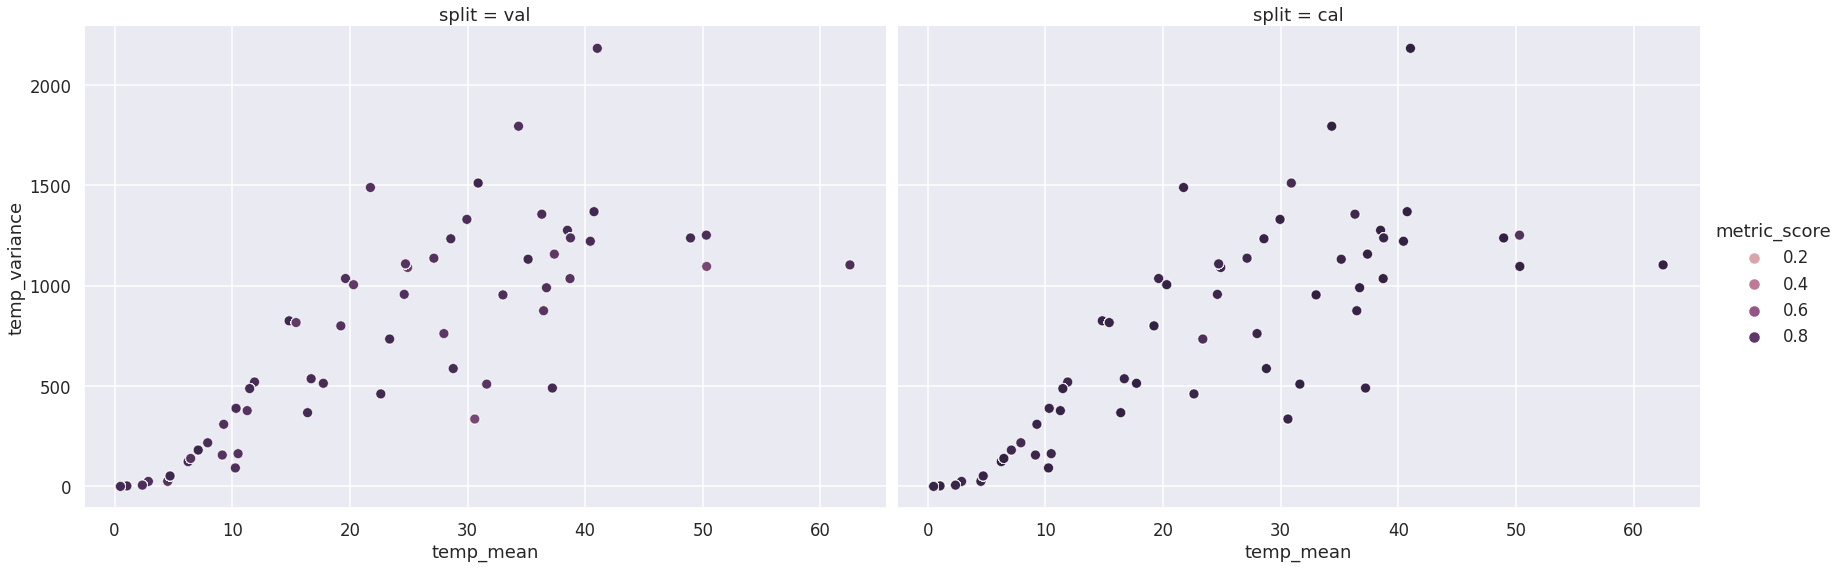

In [9]:
metric_df = image_info_df[image_info_df['image_metric'] == 'Dice']

g = sns.relplot(
    data=metric_df,
    x='temp_mean',
    y='temp_variance',
    hue='metric_score',
    col='split',
    kind='scatter',
    height=8,
    aspect=1.5,
    s=100,
    alpha=0.7,
)

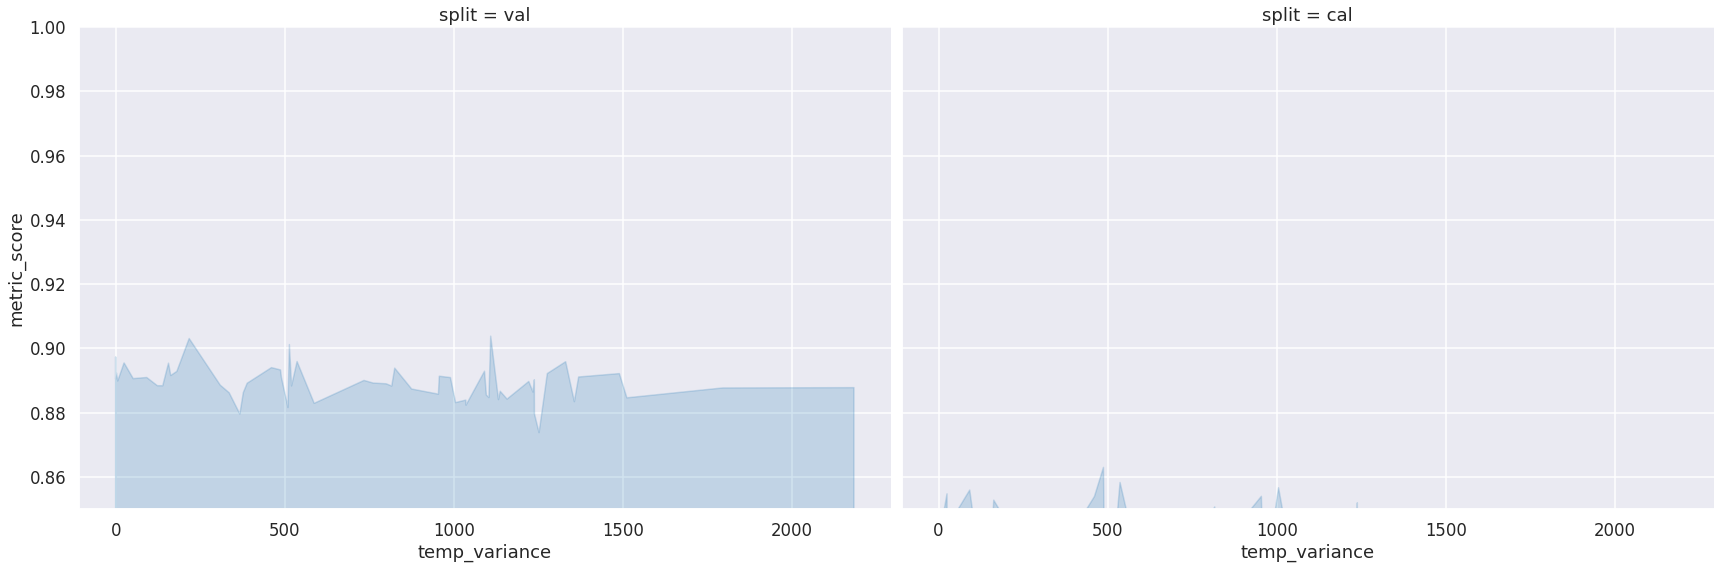

In [21]:
metric_df = image_info_df[image_info_df['image_metric'] == 'Dice']

g = sns.relplot(
    data=metric_df,
    x='temp_variance',
    y='metric_score',
    col='split',
    kind='line',
    height=8,
    aspect=1.5,
)

# g.set(ylim=(0.85, 1.0))

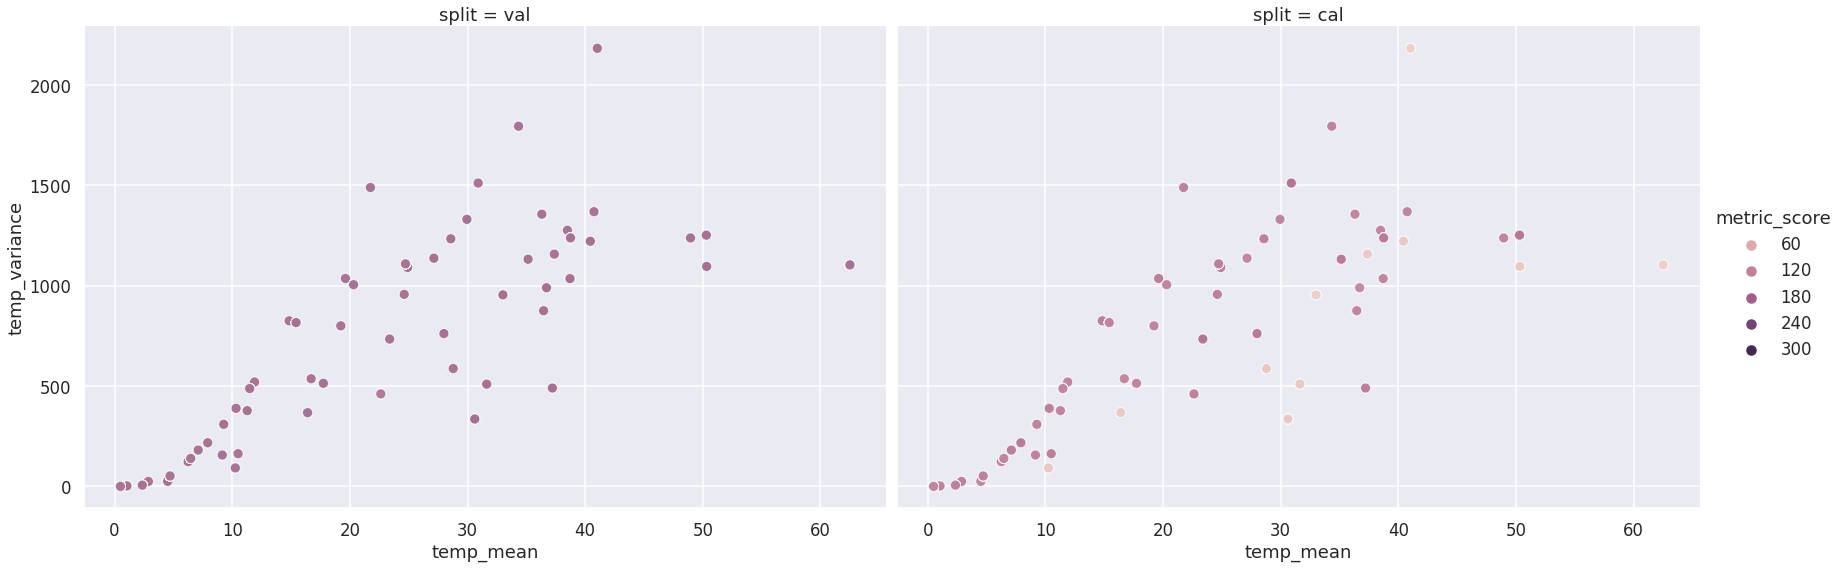

In [10]:
metric_df = image_info_df[image_info_df['image_metric'] == 'HD95']

g = sns.relplot(
    data=metric_df,
    x='temp_mean',
    y='temp_variance',
    hue='metric_score',
    col='split',
    kind='scatter',
    height=8,
    aspect=1.5,
    s=100,
    alpha=0.7,
)

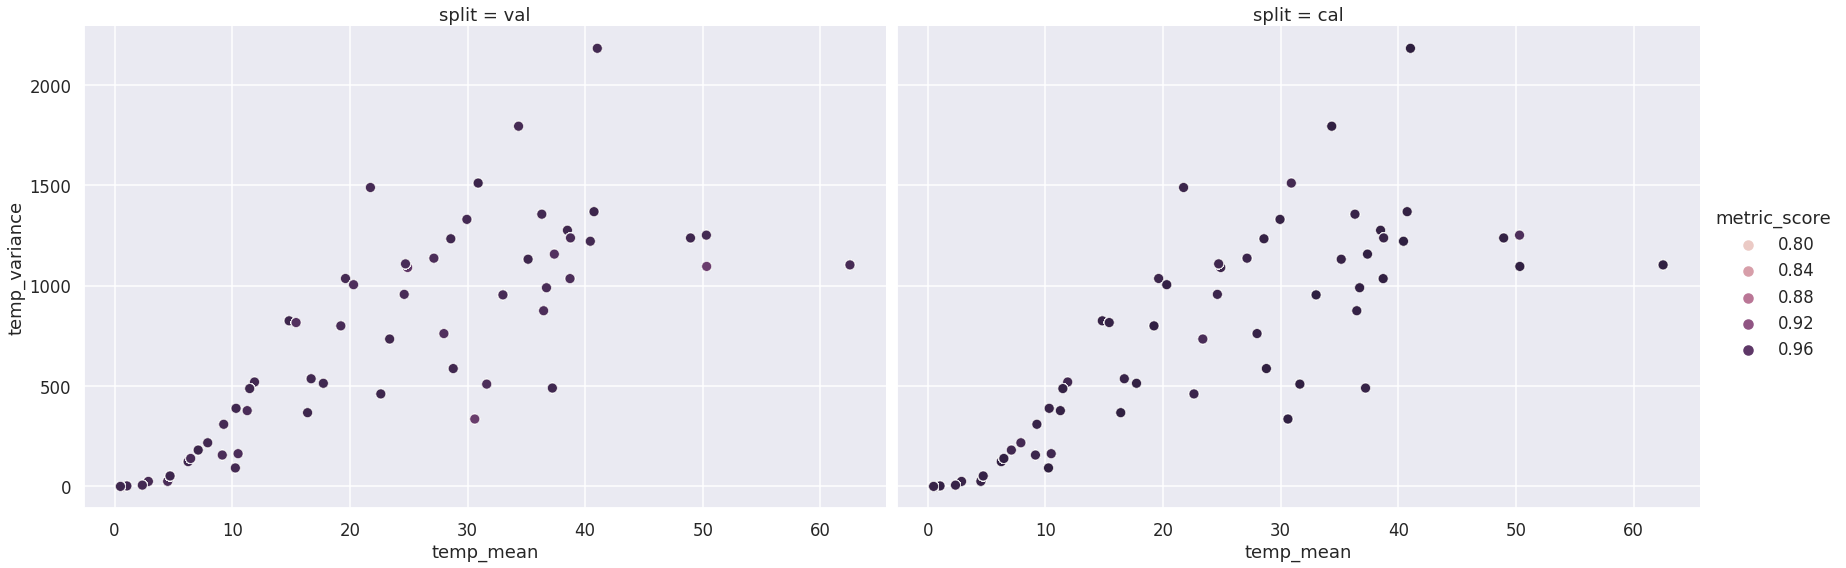

In [11]:
metric_df = image_info_df[image_info_df['image_metric'] == 'Accuracy']

g = sns.relplot(
    data=metric_df,
    x='temp_mean',
    y='temp_variance',
    hue='metric_score',
    col='split',
    kind='scatter',
    height=8,
    aspect=1.5,
    s=100,
    alpha=0.7,
)

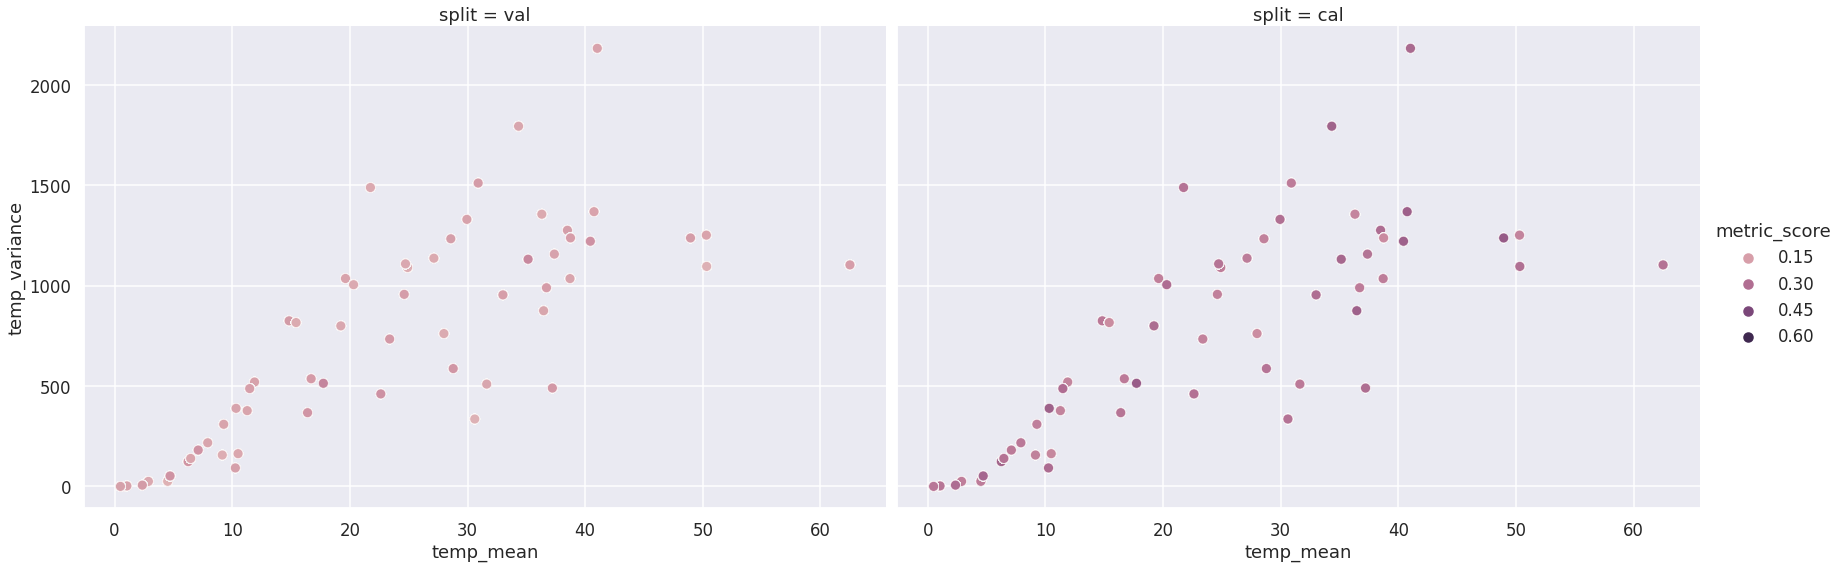

In [12]:
metric_df = image_info_df[image_info_df['image_metric'] == 'BoundaryIOU']

g = sns.relplot(
    data=metric_df,
    x='temp_mean',
    y='temp_variance',
    hue='metric_score',
    col='split',
    kind='scatter',
    height=8,
    aspect=1.5,
    s=100,
    alpha=0.7,
)